# 04 - Applied Machine Learning

## Introduction

## Summary

In [28]:
#imports and const
import pandas as pd 
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import numpy as np

DATAPATH = './'

## Question 1

### 1. A naive analysis

TODO : short intro/pres

First, let's load the data

In [7]:
df_lalonde_ori  = pd.read_csv(os.path.join(DATAPATH,"lalonde.csv"))

df_lalonde_ori.head(10) # There are 614 rows and 11 columns

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000
7,NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580
8,NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220
9,NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.0700


We will then split the dataFrame between the treatment and the control groups, we will use the treat column as our filter.
To have a first idea of our data, we will look at the description of each dataframe

In [10]:
df_treat = df_lalonde_ori.loc[df_lalonde_ori["treat"]==1]
df_control = df_lalonde_ori.loc[df_lalonde_ori["treat"]==0]
df_treat.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [11]:
df_control.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


We can see some interesting facts : 
* There are 185 subjects in the treatment group and 429 in the control group
* For columns re74, re75, re78 which are earnings the minimal value is 0, which can be either a null earning or a missing data.
    
Let's compare some figures : 

In [22]:
treat_mean_78 = df_treat['re78'].mean()
control_mean_78 = df_control['re78'].mean() 
difference_mean_78 = control_mean_78 - treat_mean_78

treat_median_78 = df_treat['re78'].median()
control_median_78 = df_control['re78'].median() 
difference_median_78 = control_median_78 - treat_median_78
print(f"Mean of earnings in 1978 for treatment group : {treat_mean_78}")
print(f"Mean of earnings in 1978 for control group : {control_mean_78}")
print(f"Difference between both : {difference_mean_78} (which represents {100*difference_mean_78/treat_mean_78}% of treatment and , {100*difference_mean_78/control_mean_78}% of control)")
print('*'*10)
print(f"Median of earnings in 1978 for treatment group : {treat_median_78}")
print(f"Median of earnings in 1978 for control group : {control_median_78}")
print(f"Difference between both : {difference_median_78} (which represents {100*difference_median_78/treat_median_78}% of treatment and , {100*difference_median_78/control_median_78}% of control)")

Mean of earnings in 1978 for treatment group : 6349.143530270271
Mean of earnings in 1978 for control group : 6984.169742307692
Difference between both : 635.0262120374209 (which represents 10.001761796844889% of treatment and , 9.092365098039515% of control)
**********
Median of earnings in 1978 for treatment group : 4232.309
Median of earnings in 1978 for control group : 4975.505
Difference between both : 743.1959999999999 (which represents 17.560060005070515% of treatment and , 14.937096837406452% of control)


TODO : analysis

Let's show the plots associated to these figures :

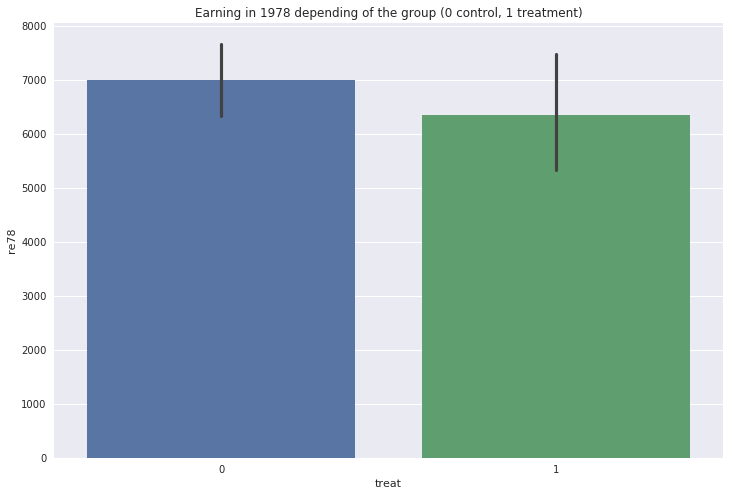

In [46]:
#First let's make a classic barplot
sb.set(style="darkgrid")
zone, plot = plt.subplots(ncols=1, sharey=True)
zone.set_size_inches(12, 8)
plot = sb.barplot(x="treat", y="re78", data=df_lalonde_ori.sort_values(["treat"],ascending=True))
plot.set_title("Earning in 1978 depending of the group (0 control, 1 treatment)")

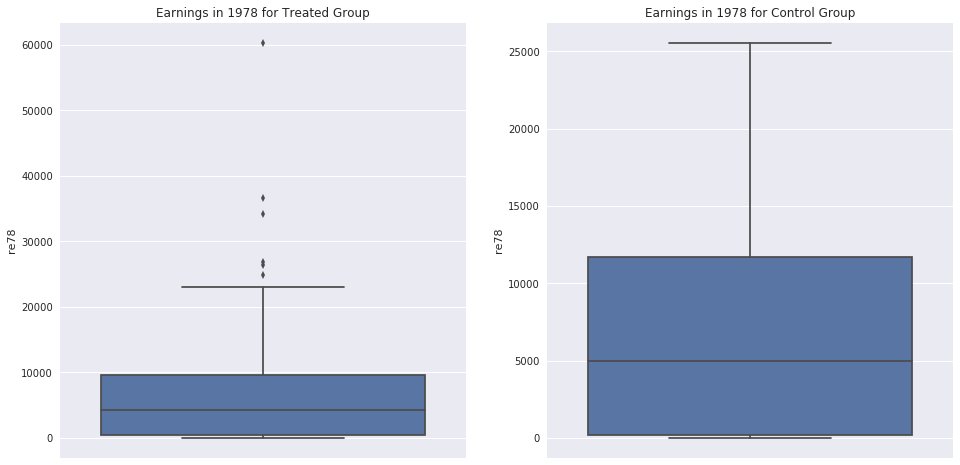

In [47]:
zone, (plot1, plot2) = plt.subplots(ncols=2)
zone.set_size_inches(16, 8)

plot1 = sb.boxplot(y = 're78' , data=df_treat, ax = plot1)
plot1.set_title("Earnings in 1978 for Treated Group")

plot2 = sb.boxplot(y = 're78' , data=df_control, ax = plot2)
plot2.set_title("Earnings in 1978 for Control Group")

It seems there are some outliers and that many values are equals to zero, to have a better understanding of the data we will use a swarmplot

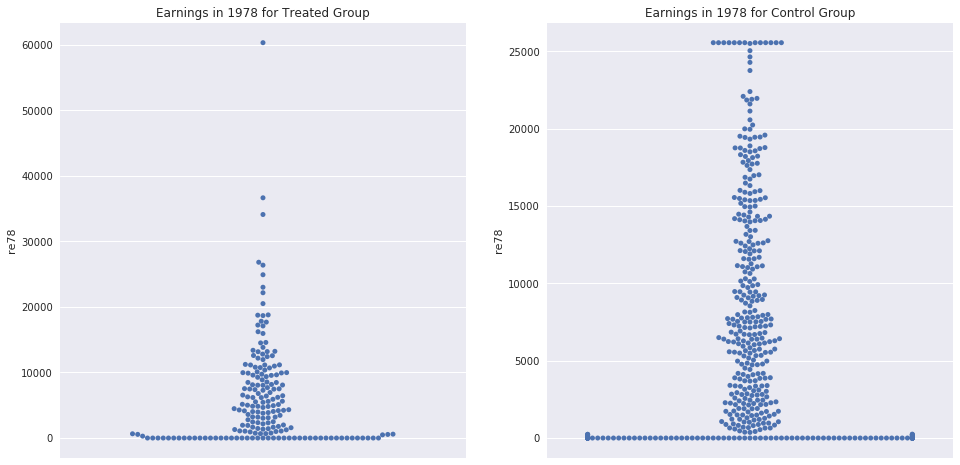

In [48]:
zone, (plot1, plot2) = plt.subplots(ncols=2)
zone.set_size_inches(16, 8)

plot1 = sb.swarmplot(y = 're78' , data=df_treat, ax = plot1)
plot1.set_title("Earnings in 1978 for Treated Group")

plot2 = sb.swarmplot(y = 're78' , data=df_control, ax = plot2)
plot2.set_title("Earnings in 1978 for Control Group")

If we remove the outliers and the values equals to 0 we obtain these figures and plots :

In [49]:
df_treat_no_zero = df_treat[df_treat['re78'] != 0]
print(f"Removed {df_treat.shape[0]-df_treat_no_zero.shape[0]} columns for treatment group ")
df_control_no_zero = df_control[df_control['re78'] != 0]
print(f"Removed {df_control.shape[0]-df_control_no_zero.shape[0]} columns for control group ")
print('*'*10)
print("Mean for treatment group without zeros: ",df_treat_no_zero['re78'].mean())
print("Median for treatment group without zeros: ",df_treat_no_zero['re78'].median())
print("Mean for control group without zeros: ",df_control_no_zero['re78'].mean())
print("Median for control group without zeros: ",df_control_no_zero['re78'].median())

Removed 45 columns for treatment group 
Removed 98 columns for control group 
**********
Mean for treatment group without zeros:  8389.939665
Median for treatment group without zeros:  6504.144499999999
Mean for control group without zeros:  9051.99039109
Median for control group without zeros:  7310.313


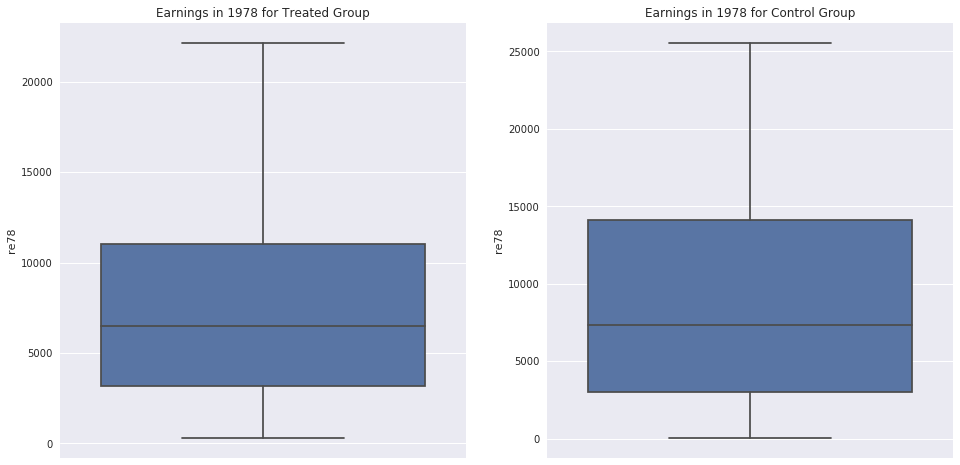

In [50]:
zone, (plot1, plot2) = plt.subplots(ncols=2)
zone.set_size_inches(16, 8)
plot1 = sb.boxplot(y = 're78' , data=df_treat_no_zero, ax = plot1, showfliers=False)
plot1.set_title("Earnings in 1978 for Treated Group")

plot2 = sb.boxplot(y = 're78' , data=df_control_no_zero, ax = plot2, showfliers=False)
plot2.set_title("Earnings in 1978 for Control Group")

The previous plots show that values are closer between each group, but we have made a strong choice by removing the zeros.

#### Conclusion of the naive analysis : 
* If we only look at the distribution of the `re78` variable, it seems that the treatment is not effective because both the mean and the median of the treated group are lower than those of the control group. This conclusion is still true when we remove zeros earning cases in both groups.


 TODO : complete ? 

### 2. A closer look at the data

We will first plot the continous values (`age`, `educ`,`re74`,`re75`), each time we will make 2 boxplots (with and without outliers), one barplot (to have a quick overview), 2 distplots(to see the exact distribution and the estimated density) and we will show the description of each group. To make our work easier we will define two functions to do it.

TODO : improve intro

In [96]:
def add_boxplot(yaxis,xaxis,title,df):
    zone, (plot1, plot2) = plt.subplots(ncols=2)
    zone.set_size_inches(16, 6)
    
    plot1 = sb.boxplot(y = yaxis ,x= xaxis, data=df, ax = plot1, showfliers=True)
    plot1.set_title(title)

    plot2 = sb.boxplot(y = yaxis ,x= xaxis, data=df, ax = plot2, showfliers=False)
    plot2.set_title(title+" without outliers")
    
    
def add_barplot(yaxis,xaxis,title,df):
    zone, plot = plt.subplots(ncols=1, sharey=True)
    zone.set_size_inches(8, 6)
    
    plot = sb.barplot(x=xaxis, y=yaxis, data=df)
    plot.set_title(title)
    
    
def add_displot(title,column):
    zone, (plot1, plot2) = plt.subplots(ncols=2)
    zone.set_size_inches(16, 6)
    
    plot1 = sb.distplot(df_treat[column],kde=False, ax=plot1)
    plot1 = sb.distplot(df_control[column],kde=False, ax=plot1)
    plot1.set_title(title)
    
    plot2 = sb.distplot(df_treat[column], hist=False,ax=plot2)
    plot2 = sb.distplot(df_control[column], hist=False,ax=plot2)
    plot2.set_title(title+" : estimated density")
    print("Control group is green and treated group is blue")
    
def show_description(column):
    mean_treated = df_treat[column].mean()
    median_treated = df_treat[column].median()
    mean_control = df_control[column].mean()
    median_control = df_control[column].median()
    print(f'Mean for treated group : {mean_treated}')
    print(f'Mean for control group : {mean_control}')
    print(f'Difference of mean: {mean_control-mean_treated}')
    print(f'Median for treated group : {median_treated}')
    print(f'Median for control group : {median_control}')
    print(f'Difference of median: {median_control-median_treated}')
    
def add_everything(column,desc):
    show_description(column)
    add_boxplot(column,"treat",desc+" based on the group",df_lalonde_ori)
    add_barplot(column,"treat",desc+" based on the group",df_lalonde_ori.sort_values([column],ascending=True))
    add_displot(f"Distribution of {desc} depending on the group",column)

**Age : **

Mean for treated group : 25.816216216216215
Mean for control group : 28.03030303030303
Difference of mean: 2.2140868140868157
Median for treated group : 25.0
Median for control group : 25.0
Difference of median: 0.0
Control group is green and treated group is blue


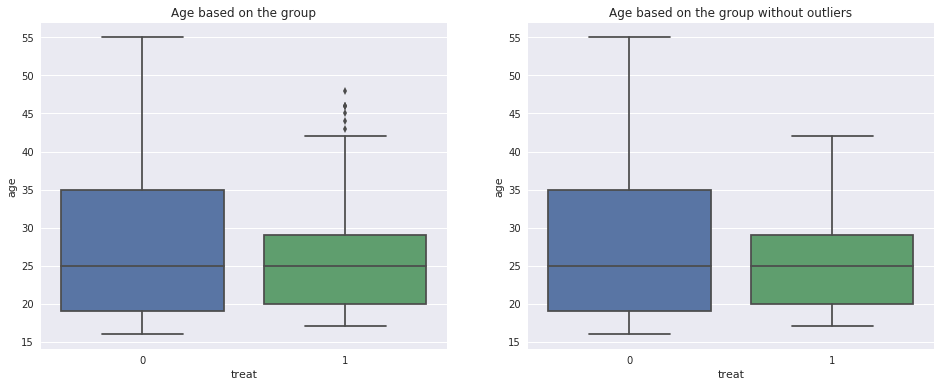

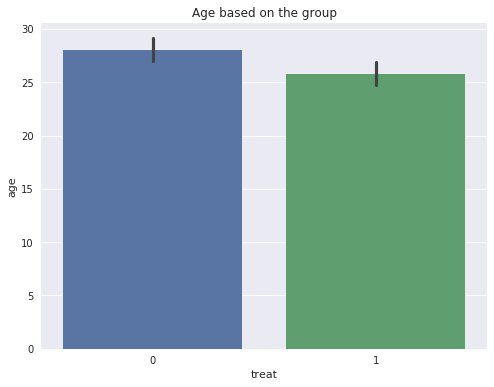

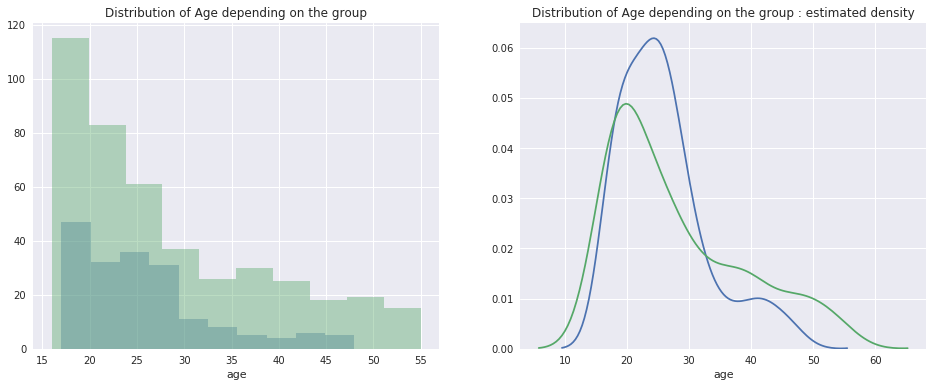

In [97]:
add_everything("age","Age")

**Education : **

Mean for treated group : 10.345945945945946
Mean for control group : 10.235431235431236
Difference of mean: -0.1105147105147104
Median for treated group : 11.0
Median for control group : 11.0
Difference of median: 0.0
Control group is green and treated group is blue


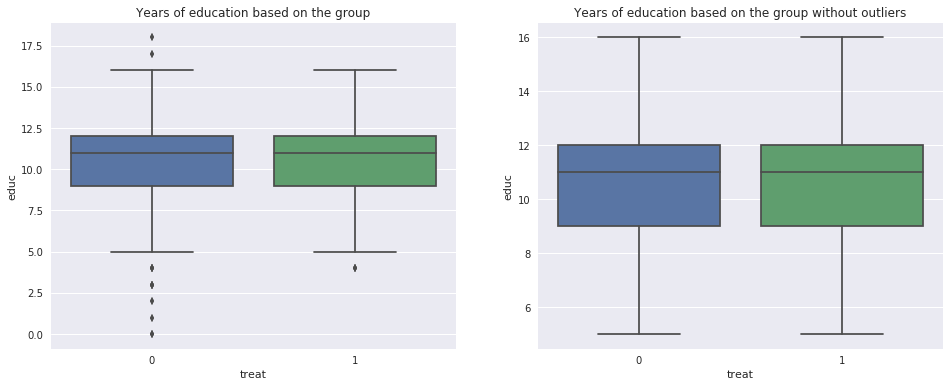

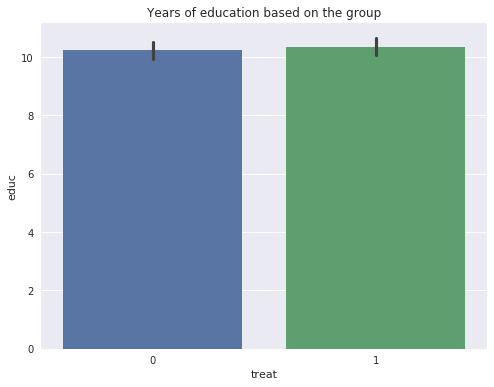

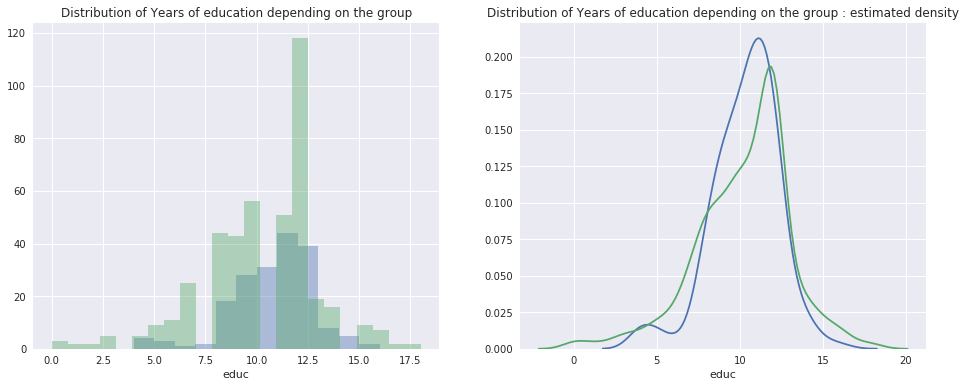

In [98]:
add_everything("educ","Years of education")

** re74 :**

Mean for treated group : 2095.573688648649
Mean for control group : 5619.2365063869465
Difference of mean: 3523.6628177382977
Median for treated group : 0.0
Median for control group : 2547.047
Difference of median: 2547.047
Control group is green and treated group is blue


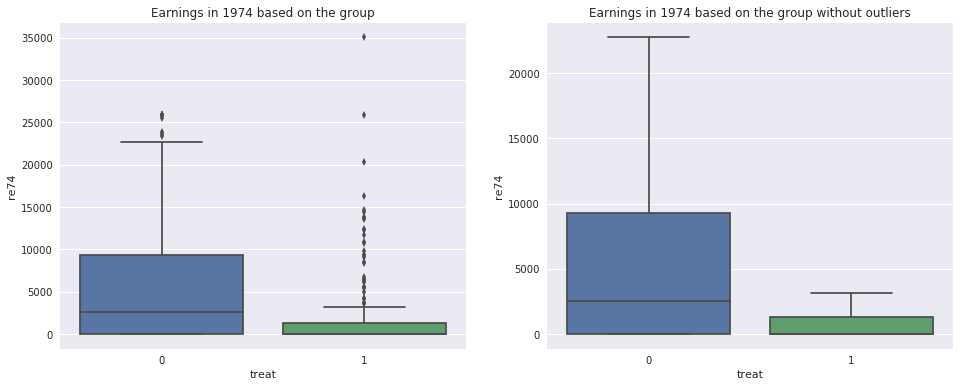

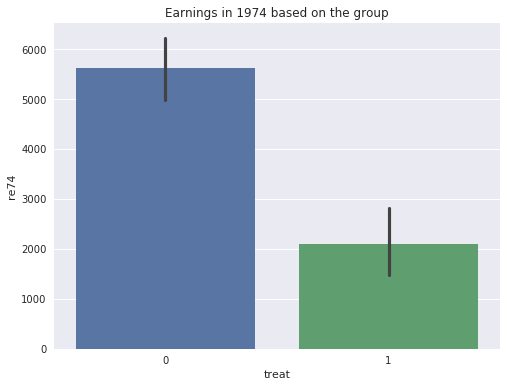

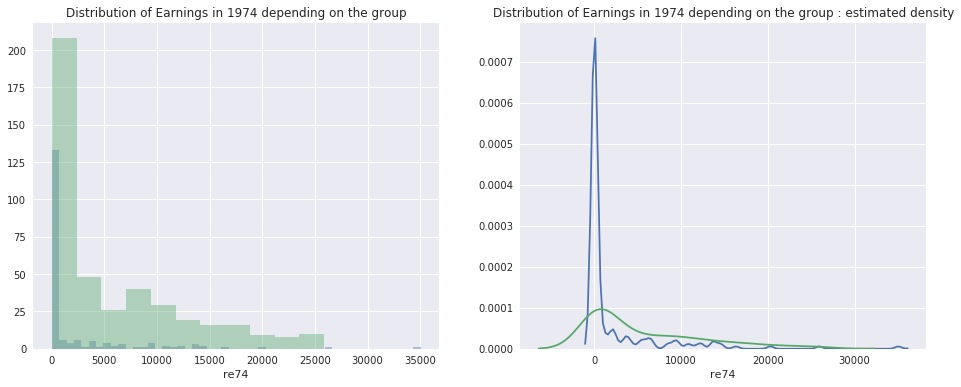

In [100]:
add_everything('re74',"Earnings in 1974")

** re75 : **

Mean for treated group : 1532.0553137837837
Mean for control group : 2466.484443123543
Difference of mean: 934.4291293397591
Median for treated group : 0.0
Median for control group : 1086.726
Difference of median: 1086.726
Control group is green and treated group is blue


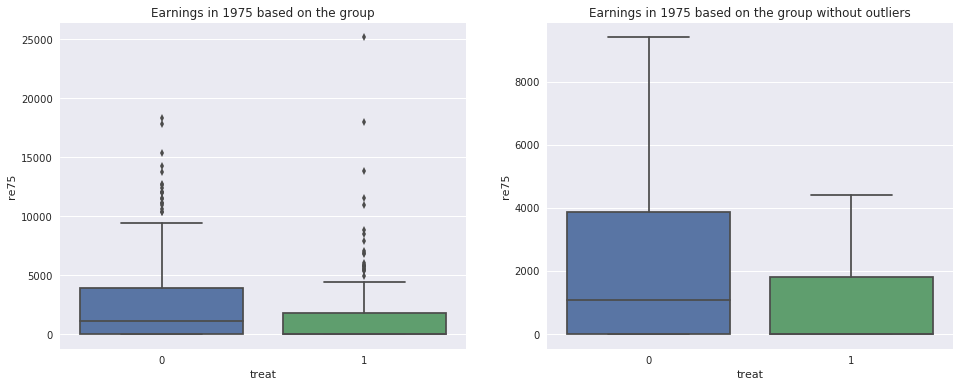

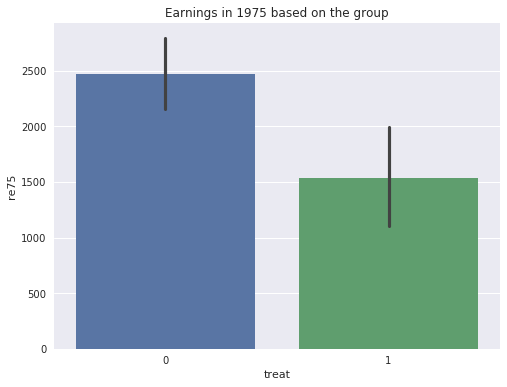

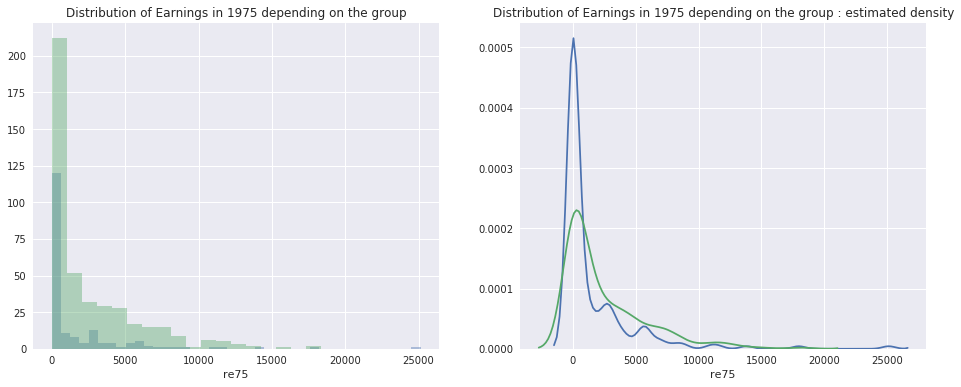

In [101]:
add_everything('re75',"Earnings in 1975")

TODO : analysis of previous figures and plots

For categorical data, we will print the number and the percentage for each group. 
We will only plot the percentage per group since it is not very representative to show the number (size of the groups are not equal)

In [122]:
population_treated = df_treat.shape[0]
population_control = df_control.shape[0]

def feature_analysis(feature,desc,in_df=True,feature2=None):
    if in_df:
        df_feat = df_lalonde_ori.loc[df_lalonde_ori[feature]==1]
    #We add this condition to handle the case of categorical values with 3 values eg whith one of them not in the df
    # i.e:white people are people non black and non hispanic
    else : 
        df_nofeat_1 = df_lalonde_ori.loc[df_lalonde_ori[feature]==0]
        df_feat = df_nofeat_1[df_nofeat_1[feature2]==0]
    population_feature_treated = df_feat.loc[df_feat["treat"]==1].shape[0]
    population_feature_control = df_feat.loc[df_feat["treat"]==0].shape[0]
    percentage_feature_treated = 100*population_feature_treated/population_treated
    percentage_feature_control = 100*population_feature_control/population_control
    print(f'Total number of {desc} : {df_feat.shape[0]}')
    print(f'Number of {desc} in the treatment group : {population_feature_treated}, which represents {percentage_feature_treated}% of the treated group')
    print(f'Number of {desc} in the control group : {population_feature_control}, which represents {percentage_feature_control}% of the control group')
    print()
    return percentage_feature_treated,percentage_feature_control

def get_categorical_results():
    #We define a dict wich associate each categorical value with a description
    associate_feature_desc = {"black":"Black people","hispan":"Hispanic people","white":"White people","married":"Married people","nodegree":"People without degree"}
    df_res = pd.DataFrame(columns=["Feature","Percentage treatment","Percentage control"])
    for key, value in associate_feature_desc.items(): 
        if key == "white":
            p_t,p_c = feature_analysis("black",value,in_df=False,feature2="hispan") 
        else:
            p_t,p_c = feature_analysis(key,value)
        df_res.loc[df_res.shape[0]] = [key,p_t,p_c]
    return df_res

df_categorical = get_categorical_results()
df_categorical

Total number of Black people : 243
Number of Black people in the treatment group : 156, which represents 84.32432432432432% of the treated group
Number of Black people in the control group : 87, which represents 20.27972027972028% of the control group

Total number of Hispanic people : 72
Number of Hispanic people in the treatment group : 11, which represents 5.945945945945946% of the treated group
Number of Hispanic people in the control group : 61, which represents 14.21911421911422% of the control group

Total number of White people : 299
Number of White people in the treatment group : 18, which represents 9.72972972972973% of the treated group
Number of White people in the control group : 281, which represents 65.5011655011655% of the control group

Total number of Married people : 255
Number of Married people in the treatment group : 35, which represents 18.91891891891892% of the treated group
Number of Married people in the control group : 220, which represents 51.282051282051285

,Feature,Percentage treatment,Percentage control
0,black,84.324324,20.279720
1,hispan,5.945946,14.219114
2,white,9.729730,65.501166
3,married,18.918919,51.282051
4,nodegree,70.810811,59.673660


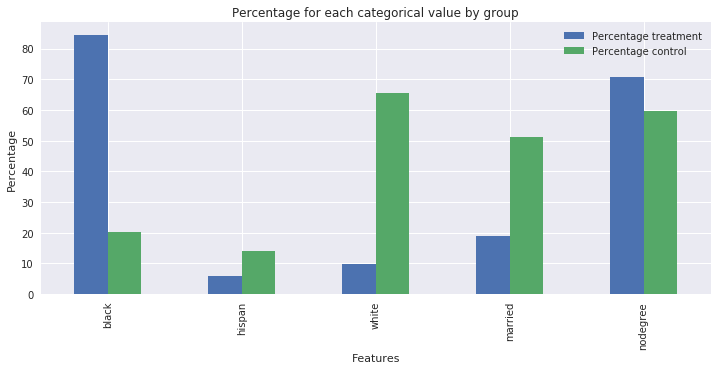

In [123]:
plot = df_categorical.plot.bar(y=["Percentage treatment","Percentage control"],x=["Feature"], figsize=(12,5))
plot.set_xlabel('Features');
plot.set_ylabel('Percentage');
plot.set_title('Percentage for each categorical value by group');

TODO : analysis of categorical data

TODO : global analysis for q 1.2

## Question 2